In [2]:
from pathlib import Path
from xpinn import XPINN
from pinn import PINN
import optax
from type_util import Array
from jax import jacobian, jit, vmap
import jax.numpy as np

# Initializing the XPINN
We begin by reading the points from the relevant file, and setting the activation function for the networks.

In [3]:
from utils import data_path

file = data_path / "advection_constraints.json"
file_test = data_path / "advection_constraints_test.json"
xpinn = XPINN(file, np.tanh)

We plot the points of the domain decomposition. This is beneficial in keeping track of which sub-PINN has which index.

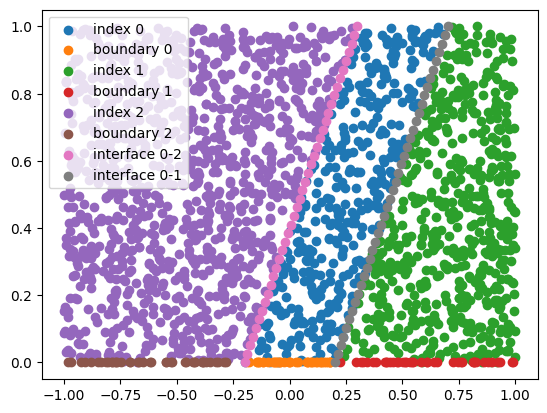

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

# Problem specifications
We consider the 1-D advection equation, defined by
$$
\begin{equation}
    u_t + 0.5 u_x = 0, \quad x \in [-1, 1], t \in [0, 1]
\end{equation}
$$
with the initial conditions
$$
\begin{cases}
    u(x, 0) = 1 & x \in [-0.2, 0.2] \\
    u(x, 0) = 0 & \text{otherwise}
\end{cases}
$$
In the middle PINN, we can set the boundary loss simply as
$$
\begin{equation}
    \lVert \mathcal{N}_{\theta}(x_b, 0) - 1 \rVert_2,
\end{equation}
$$
while for the left and right PINNs we set
$$
\begin{equation}
    \lVert \mathcal{N}_{\theta}(x_b, 0) - 0\rVert_2,
\end{equation}
$$

## Setting the loss function

We create a base function for intializing the boundary loss functions, which is relatively simple in this case.

In [5]:
from typing import Callable
from type_util import Params

LFunc = Callable[[Params, dict[str, Array]], Array]


def create_boundary_loss(index: int, target: float | Array) -> LFunc:
    def boundary_loss(params: Params, args: dict[str, Array]) -> Array:
        points = args["boundary"]
        eval = xpinn.PINNs[index].v_model(params, points)
        return np.mean((eval - target) ** 2)

    return boundary_loss

We precompute the relevant derivatives of the interior loss function, in order to speed things up down the line.

In [6]:
# fmt: off
def create_interior_loss(index: int, alpha: float = 0.5) -> LFunc:
    model = xpinn.PINNs[index].model
    jacob = lambda params: jacobian(lambda x: model(params, x))
    N_dx = lambda params, x: jacob(params)(x)[0, 0]
    N_dt = lambda params, x: jacob(params)(x)[0, 1]
    residual = lambda params, x: (N_dt(params, x) + alpha * N_dx(params, x))
    # v_residual = vmap(residual, (None, 0))
    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual

    def interior_loss(params: Params, args: dict[str, Array]) -> Array:
        points = args["interior"]
        return np.mean(v_residual(params, points) ** 2)

    return interior_loss
# fmt: on

We now override the boundary and interior loss function of the networks to the updated versions.

In [7]:
p0, p1, p2 = xpinn.PINNs

p0.boundary_loss = create_boundary_loss(0, 1.0)
p1.boundary_loss = create_boundary_loss(1, 0.0)
p2.boundary_loss = create_boundary_loss(2, 0.0)

p0.interior_loss = create_interior_loss(0)
p1.interior_loss = create_interior_loss(1)
p2.interior_loss = create_interior_loss(2)

In the interface losses, we rely on outside communication for updating the values.

In [8]:
def create_inter(i: int, j: int) -> LFunc:

    a, b = sorted([i, j])
    pi = xpinn.PINNs[i]

    def interface_loss(params: Params, args: dict[str, Array]) -> Array:
        inter_points = args[f"interface {a}{b}"]

        res_j = args[f"interface res {j}"]
        res_ij = np.mean((pi.v_residual(params, inter_points) - res_j) ** 2)
        # res_ij = 0

        val_j = args[f"interface val {j}"]
        avg_ij = np.mean(((pi.v_model(params, inter_points) - val_j) / 2) ** 2)
        # avg_ij = 0

        return res_ij + avg_ij

    # return lambda params, args: 0
    return interface_loss

Again, setting the updated functions.

In [9]:
p0.interface_loss = lambda params, args: create_inter(0, 1)(
    params, args
) + create_inter(0, 2)(params, args)
# p0.interface_loss = lambda params, args: 0
p1.interface_loss = lambda params, args: create_inter(1, 0)(params, args)
p2.interface_loss = lambda params, args: create_inter(2, 0)(params, args)

We can now set the total loss for each network

## Setting up the arcitechture of the network

In [10]:
shapes = [[2] + [20] * 6 + [1]] * 3
optimizer = optax.adam(learning_rate=1e-3)
xpinn.initialize_params(shapes, optimizer)

"""
exponential_decay = optax.exponential_decay(
    init_value=0.001,
    transition_steps=10000,
    transition_begin=15000,
    decay_rate=0.1,
    end_value=0.0000001,
)
optimizer = optax.adam(learning_rage=exponential_decay)
"""

/Users/kjeks/Documents/Utdanning/UiO-emner/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:24: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return scale * random.normal(
/Users/kjeks/Documents/Utdanning/UiO-emner/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:26: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ), scale * random.normal(b_key, (n,), dtype=np.float64)


'\nexponential_decay = optax.exponential_decay(\n    init_value=0.001,\n    transition_steps=10000,\n    transition_begin=15000,\n    decay_rate=0.1,\n    end_value=0.0000001,\n)\noptimizer = optax.adam(learning_rage=exponential_decay)\n'

In [11]:
n_iter = 10000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 10000: Total loss = 3.17855042219162
10.00% iter = 1000 of 10000: Total loss = 0.0029411801951937377
20.00% iter = 2000 of 10000: Total loss = 0.008355773286893964
30.00% iter = 3000 of 10000: Total loss = 7.470113632734865e-05
40.00% iter = 4000 of 10000: Total loss = 4.8410959607281256e-05
50.00% iter = 5000 of 10000: Total loss = 0.0009022072481457144
60.00% iter = 6000 of 10000: Total loss = 1.6925213230933878e-05
70.00% iter = 7000 of 10000: Total loss = 1.293741911467805e-05
80.00% iter = 8000 of 10000: Total loss = 1.3267729855215293e-05
90.00% iter = 9000 of 10000: Total loss = 5.4246813476765965e-06
100.00% iter = 10000 of 10000: Total loss = 4.6714649215573445e-06


It's limited how low the loss can be for this problem, while still being physically correct. This stems from the inherent discontinuity from the interfaces, specifically from the averaging of the predicted values. If we in the interface loss function set `avg_ij` to be constant zero, the networks give a lot better results. Here, we want one side of the interface to predict constant $0$, while we want the other side to predict $1$. It can be discussed what the right approach in handling this problem is, given both the simplicity of the problem, and the fact that we have the analytical solution readily available.

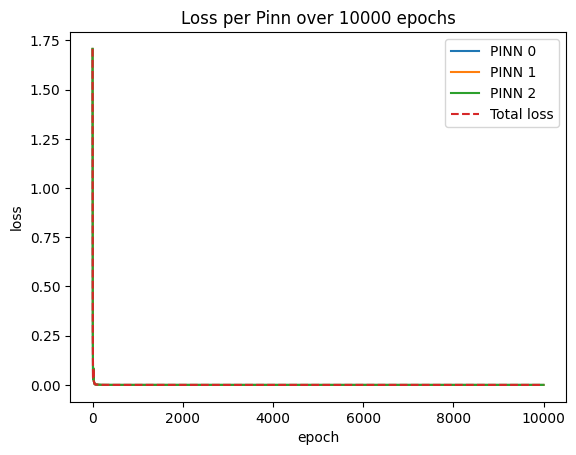

In [24]:
def plot_losses(a_losses: Array, t_0=0, n_iter=10000, no_pinns=3) -> None:
    t = np.arange(t_0, n_iter)
    for i in range(no_pinns):
        plt.plot(t, a_losses[i, t_0:], label=f"PINN {i}")
    plt.plot(t, np.sum(a_losses, axis=0)[t_0:], "--", label="Total loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.title(f"Loss per Pinn over {n_iter} epochs")
plot_losses(losses)

Without looking further into the behaviour at present time, it seems like all of the networks predict values close to zero in the begninning. This leads to it seemingly being correct for PINNs 1 and 2, and seriously wrong for PINN 0. This is expected, as in the begninning epochs the models have not been trained yet. As PINN 0 improves, it starts predicting non-zero values, lowering it's own loss. However, we see that the loss for models 1 and 2 begins increasing, which I assume comes from an increased interface loss.

In [13]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
# min_, max_ = total_pred.min(), total_pred.max()
min_, max_ = 0, 1

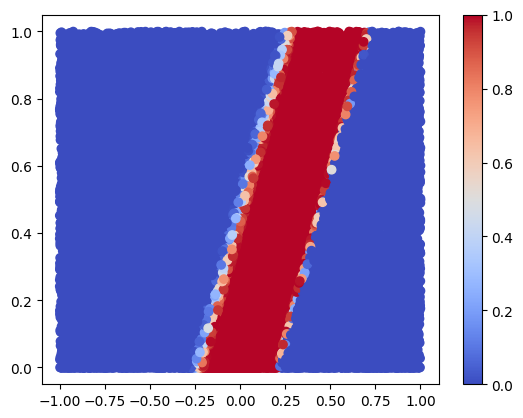

In [14]:
for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="coolwarm")
    plt.clim(min_, max_)

plt.colorbar()

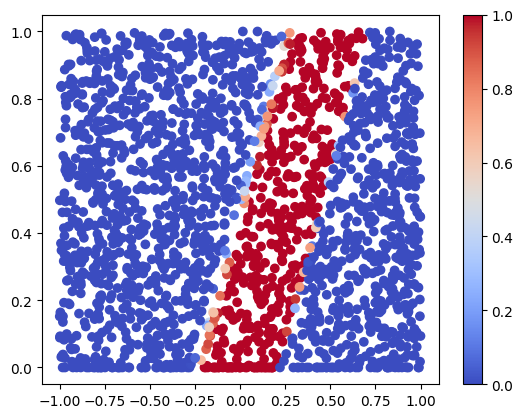

In [15]:
points, predictions = xpinn.predict()
total_pred = np.concatenate(predictions)
# min_, max_ = total_pred.min(), total_pred.max()
min_, max_ = 0, 1


for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="coolwarm")
    plt.clim(min_, max_)

plt.colorbar()

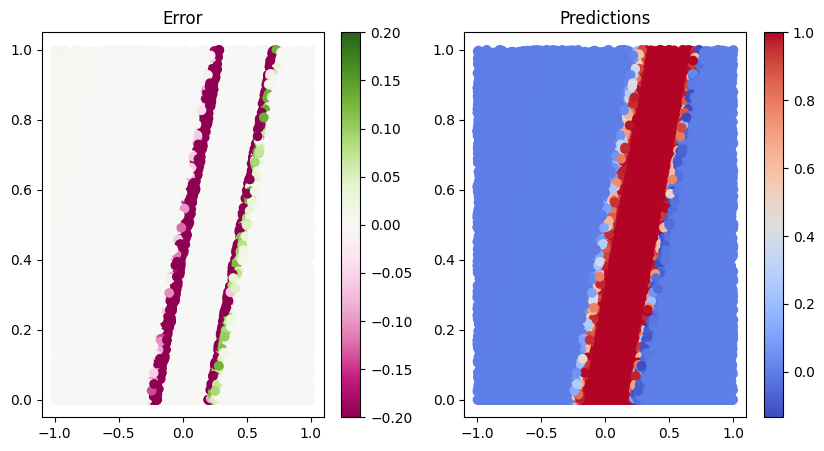

In [32]:
def analytical_value(x, t):
    condition = (x - 0.5 * t > -0.2) & (x - 0.5 * t < 0.2)
    return np.where(condition, 1, 0)

def compare_analytical_advection(xpinn: XPINN, file_test=None, min_=-1, max_=1):
    points, predictions = xpinn.predict(file_test)
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)

    # Compute all errors and predictions first
    # Avoid using mean square to understand direction of prediction
    errors = [(analytical_value(point[:, 0], point[:, 1]) - pred[:, 0]) for point, pred in zip(points, predictions)]
    predictions_vals = [pred[:, 0] for _, pred in zip(points, predictions)]

    # Aggregate all points for plotting
    all_points_x = np.concatenate([point[:, 0] for point in points])
    all_points_y = np.concatenate([point[:, 1] for point in points])
    all_errors = np.concatenate(errors)
    all_predictions = np.concatenate(predictions_vals)

    # Scatter plot for errors
    scatter1 = ax1.scatter(all_points_x, all_points_y, c=all_errors, cmap="PiYG")
    ax1.set_title("Error")
    scatter1.set_clim(min_, max_)
    plt.colorbar(scatter1, ax=ax1)  # Add one colorbar based on the errors

    # Scatter plot for predictions
    scatter2 = ax2.scatter(all_points_x, all_points_y, c=all_predictions, cmap="coolwarm")
    ax2.set_title("Predictions")
    plt.colorbar(scatter2, ax=ax2)  # Add one colorbar based on the predictions
compare_analytical_advection(xpinn, file_test, min_=-0.2, max_=0.2)


Here we see that the model predicts the interior of each subdomain correctly. When falsely predicting it biases towards one at the intersections. It also has a few false zeros but only on the intersection with the rightmost domain.

## Stress testing the model
To ensure the network is acctually learning the boundaries from its cost function and not the subdomains themselves, we create a new model with a different velocity such that
\begin{equation}
    u_t + (-1) u_x = 0, \quad x \in [-1, 1], t \in [0, 1]
\end{equation}
But with the same subdomains as defined in advection_points.ipynb

In [17]:
xpinn_n = XPINN(file, np.tanh)

p0_n, p1_n, p2_n = xpinn_n.PINNs

p0_n.boundary_loss = create_boundary_loss(0,1.0)
p1_n.boundary_loss = create_boundary_loss(1, 0.0)
p2_n.boundary_loss = create_boundary_loss(2, 0.0)

alpha=-1

p0_n.interior_loss = create_interior_loss(0, alpha)
p1_n.interior_loss = create_interior_loss(1, alpha)
p2_n.interior_loss = create_interior_loss(2, alpha)

p0_n.interface_loss = lambda params, args: create_inter(0, 1)(
    params, args
) + create_inter(0, 2)(params, args)
p1_n.interface_loss = lambda params, args: create_inter(1, 0)(params, args)
p2_n.interface_loss = lambda params, args: create_inter(2, 0)(params, args)

shapes = [[2] + [20] * 6 + [1]] * 3
optimizer = optax.adam(learning_rate=1e-3)
xpinn_n.initialize_params(shapes, optimizer)

n_iter = 10000
losses = xpinn_n.run_iters(n_iter)

/Users/kjeks/Documents/Utdanning/UiO-emner/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:24: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return scale * random.normal(
/Users/kjeks/Documents/Utdanning/UiO-emner/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:26: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ), scale * random.normal(b_key, (n,), dtype=np.float64)


0.00% iter = 0 of 10000: Total loss = 3.1582764089107513
10.00% iter = 1000 of 10000: Total loss = 0.02101170364767313
20.00% iter = 2000 of 10000: Total loss = 0.006905100308358669
30.00% iter = 3000 of 10000: Total loss = 0.0004907752954750322
40.00% iter = 4000 of 10000: Total loss = 6.0683340052491985e-05
50.00% iter = 5000 of 10000: Total loss = 6.773666063963901e-05
60.00% iter = 6000 of 10000: Total loss = 9.77440691940501e-06
70.00% iter = 7000 of 10000: Total loss = 1.798457947188581e-05
80.00% iter = 8000 of 10000: Total loss = 7.282257996621411e-06
90.00% iter = 9000 of 10000: Total loss = 3.3594900124001015e-05
100.00% iter = 10000 of 10000: Total loss = 2.2323188659356674e-05


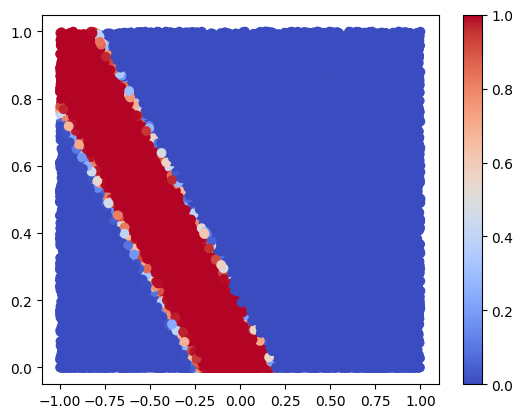

In [18]:
points, predictions = xpinn_n.predict(file_test)
total_pred = np.concatenate(predictions)
# min_, max_ = total_pred.min(), total_pred.max()
min_, max_ = 0, 1


for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="coolwarm")
    plt.clim(min_, max_)

plt.colorbar()

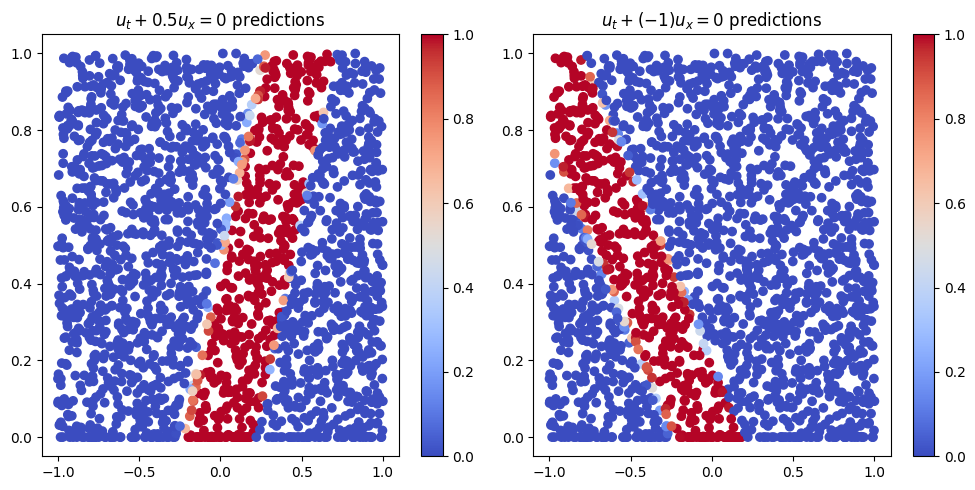

In [19]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot

points, predictions = xpinn.predict()
total_pred = np.concatenate(predictions)
min_, max_ = 0, 1
for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="coolwarm", vmin=min_, vmax=max_)

plt.colorbar()
plt.title('$u_t + 0.5 u_x = 0$ predictions')

# start second plot
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot

points, predictions = xpinn_n.predict()
total_pred = np.concatenate(predictions)

for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="coolwarm", vmin=min_, vmax=max_)

plt.colorbar()
plt.title('$u_t + (-1) u_x = 0$ predictions')

plt.tight_layout() 
plt.show()


# PINN vs XPINN

In [41]:
file_test_simple = data_path / "test_advection_simple.json"

pinn = XPINN(file_test_simple, np.tanh)

p = pinn.PINNs[0]

# This should ensure the physical constraints are satisfied
p.interior_loss = create_interior_loss(0, alpha=-0.5)

shapes = [[2] + [20] * 6 + [1]]
optimizer = optax.adam(learning_rate=1e-3)
pinn.initialize_params(shapes, optimizer)

n_iter = 1000
simple_losses = pinn.run_iters(n_iter)


/Users/kjeks/Documents/Utdanning/UiO-emner/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:24: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return scale * random.normal(
/Users/kjeks/Documents/Utdanning/UiO-emner/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:26: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ), scale * random.normal(b_key, (n,), dtype=np.float64)


0.00% iter = 0 of 1000: Total loss = 0.029757512733340263
10.00% iter = 100 of 1000: Total loss = 5.344800683815265e-06
20.00% iter = 200 of 1000: Total loss = 2.1329024093574844e-06
30.00% iter = 300 of 1000: Total loss = 1.6413166576967342e-06
40.00% iter = 400 of 1000: Total loss = 1.3686272950508283e-06
50.00% iter = 500 of 1000: Total loss = 1.169695451608277e-06
60.00% iter = 600 of 1000: Total loss = 1.0184161283177673e-06
70.00% iter = 700 of 1000: Total loss = 8.978880146059964e-07
80.00% iter = 800 of 1000: Total loss = 7.981806220414001e-07
90.00% iter = 900 of 1000: Total loss = 7.137374495869153e-07
100.00% iter = 1000 of 1000: Total loss = 6.420940508178319e-07


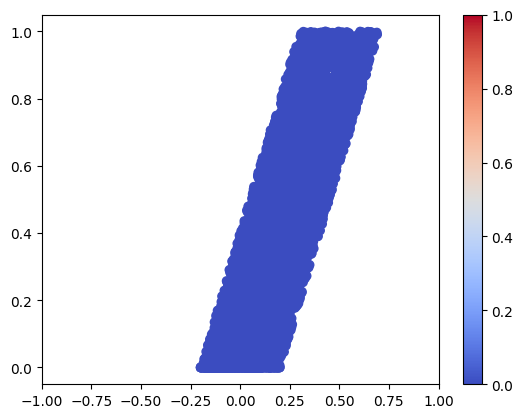

In [42]:
points, predictions = pinn.predict(file_test)
total_pred = np.concatenate(predictions)

for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="coolwarm")
    plt.clim(0, 1)

plt.xlim(-1, 1) 
plt.colorbar()